In [1]:
import os,sys,time
import numpy as np
import torch

In [2]:
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'


In [3]:
import voxelmorph as vxm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import importlib

In [4]:
file='/home-local/rudravg/registration_stress_test/512/image_pairs_v2.txt'
train_files=vxm.py.utils.read_file_list(file)
val_file='/home-local/rudravg/registration_stress_test/512/image_pairs_val_v2.txt'
val_files=vxm.py.utils.read_file_list(val_file)

In [5]:
len(train_files), train_files[0]

(2800, '/home-local/rudravg/registration_stress_test/512/image1_0.npy')

In [6]:
generator=vxm.generators.scan_to_scan(train_files)
val_generator=vxm.generators.scan_to_scan(train_files)

In [7]:
generator

<generator object scan_to_scan at 0x7fba611774c0>

In [8]:
inshape=next(generator)[0][0].shape[1:-1]
inshape

(512, 512)

In [9]:
batch=next(generator)
batch[0][0].shape

(1, 512, 512, 1)

In [10]:
model=vxm.networks.VxmDense(inshape=inshape)

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
model

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [12]:
model.to('cuda')
model.train()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
image_loss_func=vxm.losses.MSE().loss 
losses=[image_loss_func]
weights=[1]

In [14]:
losses += [vxm.losses.Grad('l2',loss_mult=2).loss]
weights += [1]

In [15]:
losses

[<bound method MSE.loss of <voxelmorph.torch.losses.MSE object at 0x7fba6105f140>>,
 <bound method Grad.loss of <voxelmorph.torch.losses.Grad object at 0x7fba620a7a70>>]

In [16]:
weights

[1, 1]

In [17]:
inputs, y_true = next(generator)
inputs1 = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in inputs]
y_true1 = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in y_true]
inputs1[0].shape, y_true1[0].shape,inputs1[1].shape

(torch.Size([1, 1, 512, 512]),
 torch.Size([1, 1, 512, 512]),
 torch.Size([1, 1, 512, 512]))

In [18]:
weights[1]

1

In [19]:
for epoch in range(20):
    if epoch==5:
        model.save('model_512_new.pt')
    epoch_loss=[]
    epoch_total_loss=[]
    epoch_step_time=[]
    for step in range(2000):
        step_time=time.time()
        inputs, y_true = next(generator)
        inputs = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in inputs]
        y_true = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in y_true]
        #print(inputs[0].shape, y_true[0].shape,inputs[1].shape)
        y_pred=model(*inputs)
        loss=0
        loss_list=[]
        for n,loss_function in enumerate(losses):
            curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
            loss_list.append(curr_loss.item())
            loss+=curr_loss
            #print(loss.item())
        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_step_time.append(time.time()-step_time)
    print(f'Epoch {epoch+1} Loss: {np.mean(epoch_total_loss)}')
    print(f'Epoch {epoch+1} Losses: {np.mean(epoch_loss, axis=0)}')
    print(f'Epoch {epoch+1} Step Time: {np.mean(epoch_step_time)}')
model.save('final_model_512_new.pt')

Epoch 1 Loss: 0.030869058672571555
Epoch 1 Losses: [0.02962963 0.00123943]
Epoch 1 Step Time: 0.031432528614997866
Epoch 2 Loss: 0.01833274813403841
Epoch 2 Losses: [0.01690095 0.0014318 ]
Epoch 2 Step Time: 0.03132188272476196
Epoch 3 Loss: 0.01545534752763342
Epoch 3 Losses: [0.01401083 0.00144452]
Epoch 3 Step Time: 0.031353785276412964
Epoch 4 Loss: 0.01551562478474807
Epoch 4 Losses: [0.01410679 0.00140883]
Epoch 4 Step Time: 0.03111210036277771
Epoch 5 Loss: 0.01386845523735974
Epoch 5 Losses: [0.01247996 0.00138849]
Epoch 5 Step Time: 0.03110472273826599
Epoch 6 Loss: 0.01655677997658495
Epoch 6 Losses: [0.01509269 0.00146409]
Epoch 6 Step Time: 0.03135742449760437
Epoch 7 Loss: 0.01477746413240675
Epoch 7 Losses: [0.01320933 0.00156813]
Epoch 7 Step Time: 0.03121708607673645
Epoch 8 Loss: 0.013311663026339375
Epoch 8 Losses: [0.01176882 0.00154285]
Epoch 8 Step Time: 0.0312349933385849
Epoch 9 Loss: 0.012982009175932036
Epoch 9 Losses: [0.0115178  0.00146421]
Epoch 9 Step Time:

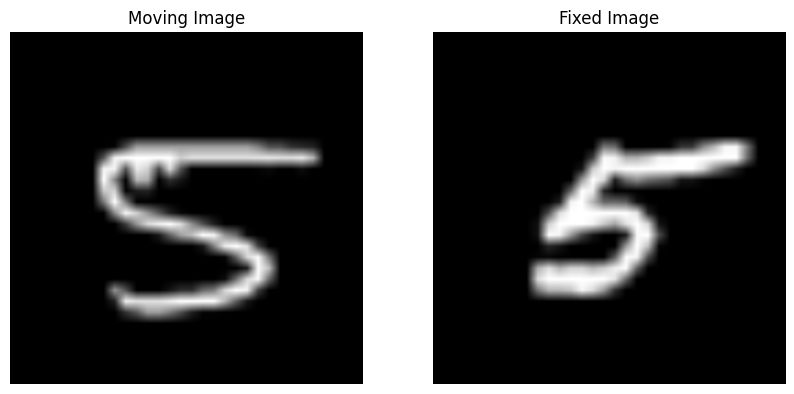

In [20]:
fixed_file='/home-local/rudravg/registration_stress_test/512/image1_2683.npy'
moving_file='/home-local/rudravg/registration_stress_test/512/image2_2684.npy'
model_path='/nfs2/forGaurav/yesbackup/DAPI_reg/vxl_morph/voxelmorph-dev/final_model_512_new.pt'
# Load the images
moving_image = np.load(moving_file)
fixed_image = np.load(fixed_file)

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the moving image
axs[0].imshow(moving_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Moving Image')

# Plot the fixed image
axs[1].imshow(fixed_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Fixed Image')

# Display the plot
plt.show()


In [21]:
fixed_image.min(),fixed_image.max(),moving_image.min(),moving_image.max()

(0.0, 1.0, 0.0, 1.0)

In [22]:
device = 'cuda'
moving=vxm.py.utils.load_volfile(moving_file,add_batch_axis=True,add_feat_axis=True)
fixed,fixed_affine=vxm.py.utils.load_volfile(fixed_file,add_batch_axis=True,add_feat_axis=True,ret_affine=True)

In [23]:
test_model=vxm.networks.VxmDense.load(model_path, device)
test_model.to(device)
test_model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [24]:
input_moving=torch.from_numpy(moving).to(device).float().permute(0,3,1,2)
input_fixed=torch.from_numpy(fixed).to(device).float().permute(0,3,1,2)


In [25]:
moved,warp=test_model(input_moving,input_fixed,registration=True)


In [26]:
moved_img=moved.detach().cpu().numpy().squeeze()
moved_img.shape
warped=warp.detach().cpu().numpy().squeeze()
warped.shape

(2, 512, 512)

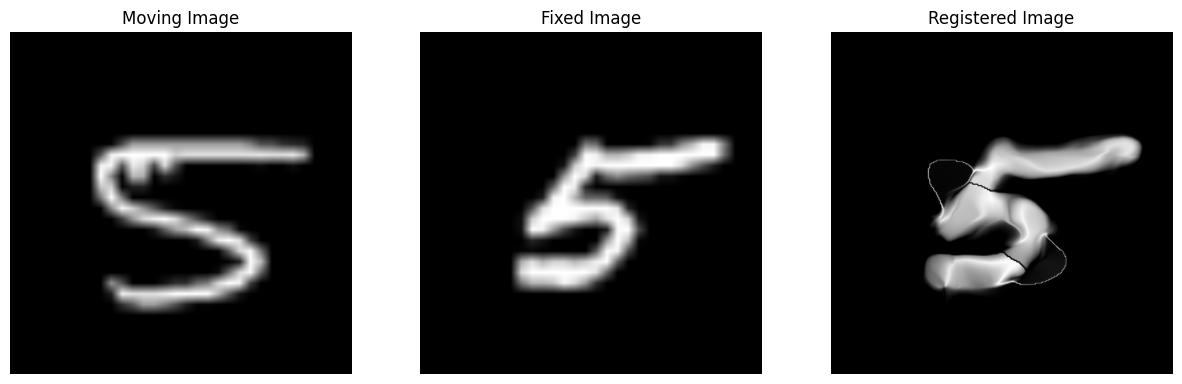

In [27]:
# Load the moving and fixed images
moving_image = np.load(moving_file)
fixed_image = np.load(fixed_file)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the moving image
axs[0].imshow(moving_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Moving Image')

# Plot the fixed image
axs[1].imshow(fixed_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Fixed Image')

# Plot the registered image
axs[2].imshow(moved_img, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Registered Image')

# Display the plot
plt.show()